In [70]:
import pandas as pd
import numpy as np
import os
import glob
import ast
# !pip install ppscore
import ppscore as pps

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [4]:
import re 
import urllib.request 
from bs4 import BeautifulSoup 

In [5]:
data = pd.read_csv('data.csv')
genres = pd.read_csv('data_by_genres.csv')
year = pd.read_csv('data_by_year.csv')
artist = pd.read_csv('data_by_artist.csv')
wgenres = pd.read_csv('data_w_genres.csv')

# Data overview

In [82]:
data.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920
2,0.993,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920


In [83]:
wgenres.head(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.0,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.0,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.0,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]


In [84]:
genres.head(3)

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.2841,352593.2,0.159580,0.484374,0.16858,-22.153400,0.062060,91.351000,0.143380,6.6,4,1
1,432hz,0.485515,0.3120,1047430.4,0.391678,0.477250,0.26594,-18.131267,0.071717,118.900933,0.236483,41.2,11,1
2,8-bit,0.028900,0.6730,133454.0,0.950000,0.630000,0.06900,-7.899000,0.292000,192.816000,0.997000,0.0,5,1


In [85]:
genres.shape

(3232, 14)

In [86]:
data.shape

(174389, 19)

In [87]:
wgenres.shape

(32539, 16)

In [88]:
year.shape

(102, 14)

In [13]:
# моя любимая группа
artist[artist.artists.str.contains('Breaking')].head(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
3827,Breaking Benjamin,0.014119,0.430102,224341.816327,0.851163,0.08578,0.137522,-4.852939,0.05892,134.312714,0.382837,51.408163,8,1,98


In [16]:
# числовые столбцы
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [17]:
# удаляю из них признаки, которые не понадобятся
drop_useless_cols = ['key', 'mode', 'year']
[num_cols.remove(i) for i in drop_useless_cols]

[None, None, None]

In [18]:
num_cols

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'popularity',
 'speechiness',
 'tempo',
 'valence']

In [19]:
len(num_cols)

12

In [20]:
round(data[num_cols].describe(), 2)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
count,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00
mean,0.50,0.54,232810.03,0.48,0.07,0.20,0.21,-11.75,25.69,0.11,117.01,0.52
std,0.38,0.18,148395.80,0.27,0.25,0.33,0.18,5.69,21.87,0.18,30.25,0.26
min,0.00,0.00,4937.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.09,0.41,166133.00,0.25,0.00,0.00,0.10,-14.91,1.00,0.04,93.93,0.31
50%,0.52,0.55,205787.00,0.46,0.00,0.00,0.14,-10.84,25.00,0.05,115.82,0.54
75%,0.90,0.67,265720.00,0.71,0.00,0.25,0.27,-7.50,42.00,0.08,135.01,0.74
max,1.00,0.99,5338302.00,1.00,1.00,1.00,1.00,3.86,100.00,0.97,243.51,1.00


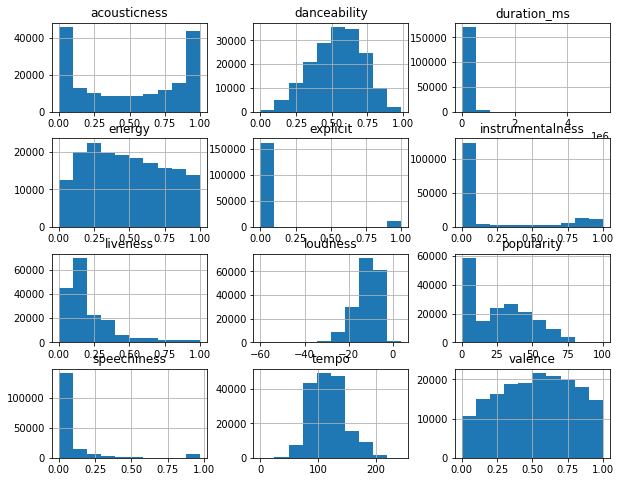

In [21]:
data[num_cols].hist(figsize=(10, 8))
plt.show()

In [89]:
matrix_df = pps.matrix(data[data.select_dtypes(include=['int64', 'float64']).columns.to_list()])[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

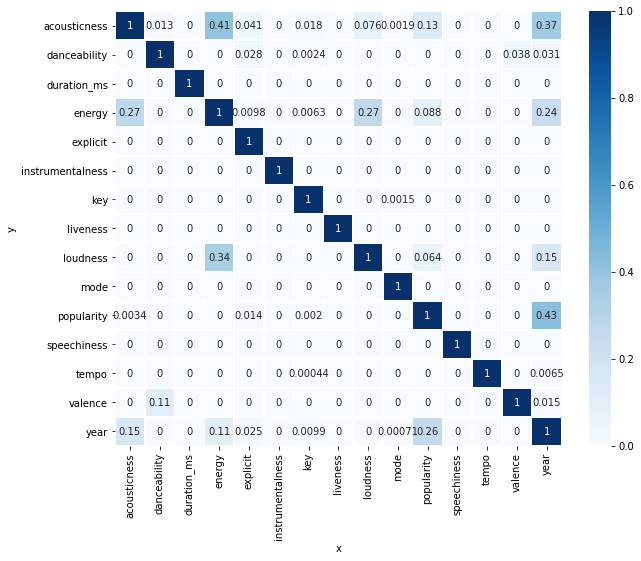

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()

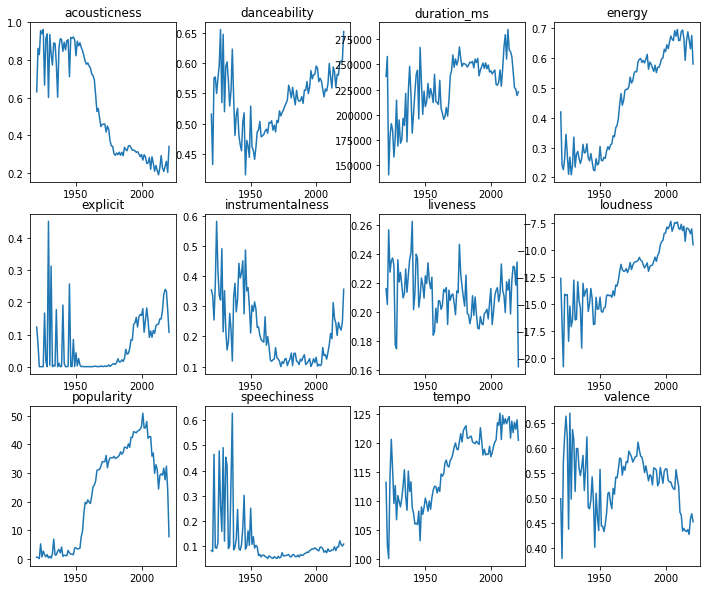

In [22]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(12, 10))
for i, col in enumerate(num_cols):
    ax[i // 4, i % 4].plot(data[[col, 'year']].groupby('year').mean())
    ax[i // 4, i % 4].set_title(col)

In [23]:
def plot_metric_over_century(col):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(year.year, col)
#     ax.set_xticks(year.year)
    plt.show()

**вопросы**
1. смена группой направления
2. самые выдающиеся экспериментальные песни. А что это за метрика - экспериментальные песни, смена направления? Как её обозначить?
3. что ценят люди в разное время. То есть предикторы популярности. Вроде выполнено.
4. взлёты и падения групп
5. запарсить может слова. Провести семантический анализ успешных песен. По жанрам. По ост. характеристикам.
6. Просто сравнить жанры.

In [24]:
kmeans = KMeans(n_clusters=1)

In [25]:
data.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

но ведь разве не должны переменные иметь разный вес?

In [26]:
def find_predictor_coefs(data, delay = 5):
    curr_year = min(year.year)
    last_year = curr_year + delay
    coefs = []
    r2_sq = []
    while last_year <= 2021:
        df = data[data.year.isin(np.arange(curr_year, last_year+1))]
        X = df[num_cols].drop('popularity', axis=1)
        y = df['popularity']
        model = LinearRegression()
        model.fit(X, y)
        coefs.append(model.coef_)
        r2_sq.append(r2_score(y, model.predict(X)))
        curr_year += 1
        last_year += 1
#     заменяем индексы на года
    coefs = pd.DataFrame(coefs)
    coefs['year'] = np.arange(min(year.year), max(year.year) - delay + 1)
    coefs = coefs.set_index('year')
    
    predictors = num_cols.copy()
    predictors.remove('popularity')
    coefs.columns = predictors
    return coefs, delay, r2_sq

In [27]:
coefs, delay, r2_sq = find_predictor_coefs(data, delay = 15)

In [29]:
predictors = num_cols.copy()
predictors.remove('popularity')

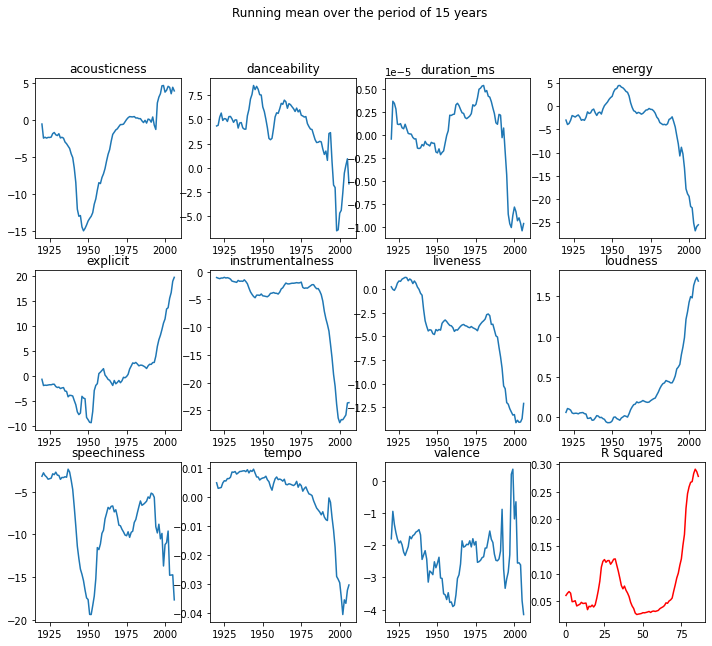

In [30]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(12, 10))
for i, col in enumerate(predictors):
    ax[i // 4, i % 4].plot(coefs[col])
#     ax[i // 4, i % 4].set_xticks(np.arange(min(year.year), max(year.year) - 4))
    ax[i // 4, i % 4].set_title(col)
i = 11
ax[i // 4, i % 4].plot(r2_sq, color='red')
ax[i // 4, i % 4].set_title('R Squared')
fig.suptitle('Running mean over the period of ' + str(delay) + ' years')
plt.show()

In [31]:
data.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920
2,0.993,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920


In [32]:
MinMaxScaler().fit_transform(data[num_cols])

array([[0.99497992, 0.60526316, 0.03063657, ..., 0.09639547, 0.61590016,
        0.634     ],
       [0.64558233, 0.86234818, 0.02723665, ..., 0.05499485, 0.35682342,
        0.95      ],
       [0.99698795, 0.6548583 , 0.0297917 , ..., 0.1791967 , 0.40080983,
        0.689     ],
       ...,
       [0.80923695, 0.6791498 , 0.03997664, ..., 0.02904222, 0.44375726,
        0.714     ],
       [0.92369478, 0.46761134, 0.04482405, ..., 0.03882595, 0.70354856,
        0.32      ],
       [0.23995984, 0.68522267, 0.03614472, ..., 0.02657055, 0.46079989,
        0.747     ]])

In [43]:
data_scale = data.copy()

In [44]:
scaler = MinMaxScaler()

In [45]:
num_cols_wout_y = num_cols.copy()
num_cols_wout_y.remove('popularity')

In [46]:
data_scale[num_cols_wout_y] = scaler.fit_transform(data_scale[num_cols_wout_y])

In [47]:
coefs, delay, r2_sq = find_predictor_coefs(data_scale, delay = 10)

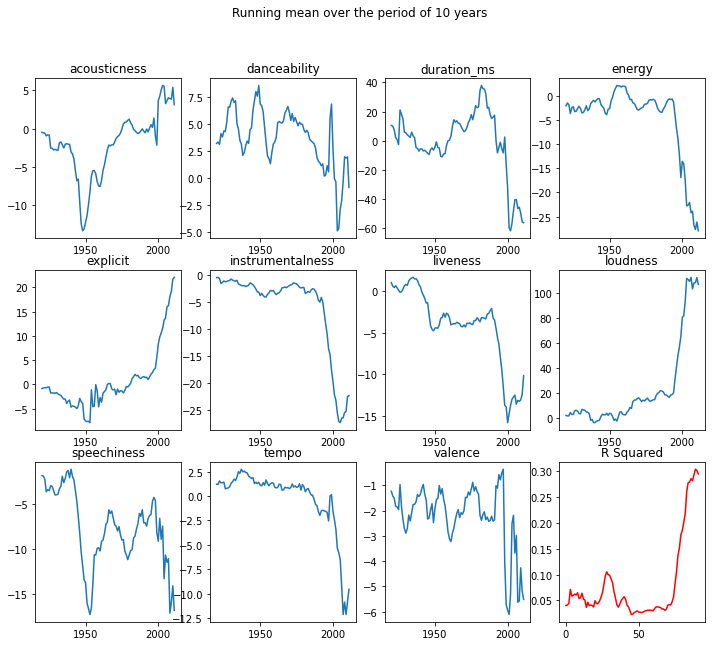

In [48]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(12, 10))
for i, col in enumerate(predictors):
    ax[i // 4, i % 4].plot(coefs[col])
#     ax[i // 4, i % 4].set_xticks(np.arange(min(year.year), max(year.year) - 4))
    ax[i // 4, i % 4].set_title(col)
i = 11
ax[i // 4, i % 4].plot(r2_sq, color='red')
ax[i // 4, i % 4].set_title('R Squared')
fig.suptitle('Running mean over the period of ' + str(delay) + ' years')
plt.show()

In [49]:
most_imp_coefs = coefs.abs().sum(axis=0).sort_values(ascending=False)[:7].index

In [50]:
most_imp_coefs

Index(['loudness', 'duration_ms', 'speechiness', 'instrumentalness', 'energy',
       'liveness', 'danceability'],
      dtype='object')

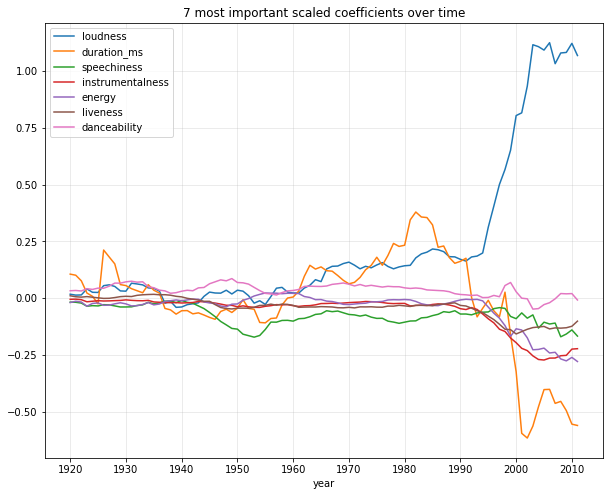

In [40]:
coefs[most_imp_coefs].plot(figsize=(10, 8))
plt.title('7 most important scaled coefficients over time')
plt.grid(alpha=0.3)
plt.xticks(np.arange(min(year.year), max(year.year) - delay + 1, 10))
plt.show()

<AxesSubplot:>

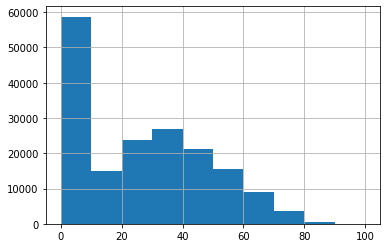

In [53]:
data_scale.popularity.hist()

<AxesSubplot:>

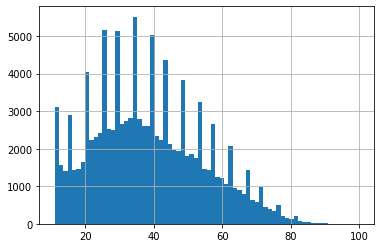

In [58]:
data_scale[data_scale.popularity > 3].popularity.hist(bins=70)

In [64]:
coefs, delay, r2_sq = find_predictor_coefs(data_scale[data_scale.popularity > 3], delay = 20)

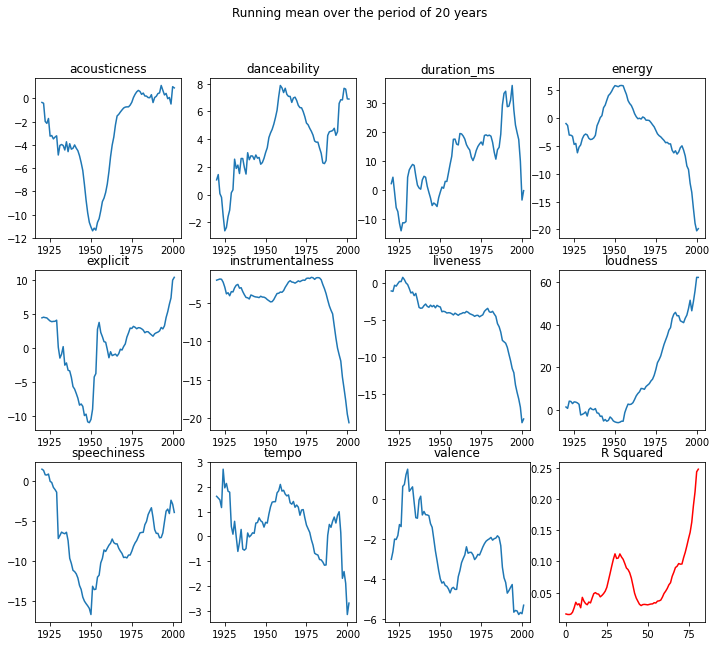

In [65]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(12, 10))
for i, col in enumerate(predictors):
    ax[i // 4, i % 4].plot(coefs[col])
#     ax[i // 4, i % 4].set_xticks(np.arange(min(year.year), max(year.year) - 4))
    ax[i // 4, i % 4].set_title(col)
i = 11
ax[i // 4, i % 4].plot(r2_sq, color='red')
ax[i // 4, i % 4].set_title('R Squared')
fig.suptitle('Running mean over the period of ' + str(delay) + ' years')
plt.show()

In [66]:
most_imp_coefs = coefs.abs().sum(axis=0).sort_values(ascending=False)[:7].index

In [67]:
most_imp_coefs

Index(['loudness', 'duration_ms', 'speechiness', 'liveness',
       'instrumentalness', 'energy', 'danceability'],
      dtype='object')

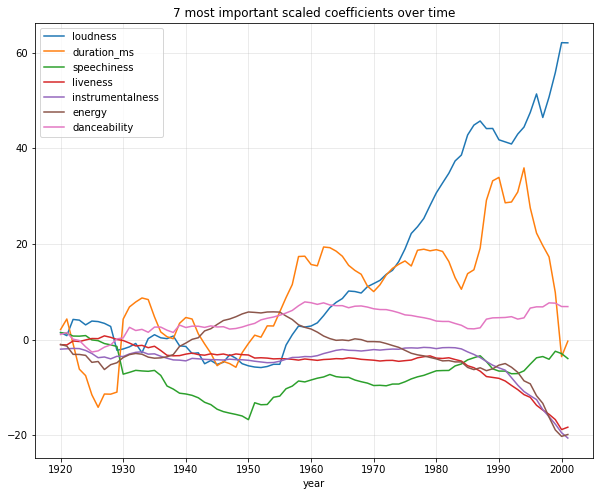

In [68]:
coefs[most_imp_coefs].plot(figsize=(10, 8))
plt.title('7 most important scaled coefficients over time')
plt.grid(alpha=0.3)
plt.xticks(np.arange(min(year.year), max(year.year) - delay + 1, 10))
plt.show()

In [ ]:
data[num_cols].iloc[0, :]

In [ ]:
np.linalg.norm(data_scale[num_cols].iloc[0, :] - data_scale[num_cols].iloc[1, :])

In [ ]:
data.columns

In [ ]:
data_scale['artists']

In [ ]:
art_year_mean = data_scale.groupby(['artists', 'year']).mean()

In [ ]:
art_year_mean.shape

In [ ]:
artists_years = {}
for artist, year in art_year_mean.index:
    if artist not in artists_years:
        artists_years[artist] = [year]
    else:
        artists_years[artist].append(year)


In [ ]:
count_years = {artist: len(year) for artist, year in artists_years.items()}

In [ ]:
pd.Series(count_years).sort_values().hist(bins=50)

In [ ]:
np.sum(pd.Series(count_years) >= 10)

409 исполнителей исполнителей выпускали музыку 10 и более лет

А сколько в данных совместных исполнителей?

In [ ]:
count_artists = pd.Series([len(i.split()) for i in data_scale['artists']])

In [ ]:
count_artists.hist(bins=10)

In [ ]:
count_artists.mean()

Эмм. Тогда нельзя слепо разделять артистов по названию.
Можно найти самых общительных (которые встречались с большим кол-вом артистов)    
Что то можно с уменьшением размерности. И ещё расстояния может...

А какие есть жанры

In [ ]:
genres_list = []
for genres in wgenres['genres']:
    for genre in ast.literal_eval(genres):
        genres_list.append(genre)

In [ ]:
pd.Series(genres_list).value_counts()[:15]

А ещё жанры между собой пересекаются по названию

In [ ]:
# wgenres[wgenres['genres'].str.contains('russian pun')]

In [ ]:
wlyrics = pd.read_csv('spotify_songs.csv')

In [ ]:
wlyrics.head(3)

In [ ]:
wlyrics.columns

In [ ]:
wlyrics[wlyrics.language == 'en'].lyrics

In [ ]:
data.columns

id, к сожалению, не уникальные. Поэтому соединяем по названиям

In [ ]:
pd.merge(data, wlyrics, how='right', right_on='track_name', left_on='name')
# очень грубо

In [ ]:
# https://www.quora.com/Whats-a-good-API-to-use-to-get-song-lyrics

def get_lyrics(artist,song_title): 
    artist = artist.lower() 
    song_title = song_title.lower() 
    # remove all except alphanumeric characters from artist and song_title 
    artist = re.sub('[^A-Za-z0-9]+', "", artist) 
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title) 
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who 
        artist = artist[3:] 
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html" 
     
    try: 
        content = urllib.request.urlopen(url).read() 
        soup = BeautifulSoup(content, 'html.parser') 
        lyrics = str(soup) 
        # lyrics lies between up_partition and down_partition 
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->' 
        down_partition = '<!-- MxM banner -->' 
        lyrics = lyrics.split(up_partition)[1] 
        lyrics = lyrics.split(down_partition)[0] 
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').strip() 
        return lyrics 
    except Exception as e: 
        return "Exception occurred \n" +str(e) 

In [ ]:
get_lyrics('Neck Deep', 'December')